<center><h2><b><u> Multilayer Perceptron with MNIST Dataset</u></b></h2></center>

### __Importing Libraries, Classes, and Functions__

In [581]:
from operator import itemgetter
import numpy as np
import torch
import torch.nn as nn #provides classes/modules for making neural networks
from torch.nn import Linear
import torch.nn.functional as F #a module with common nn functions (operations on tensors/high dim matrices; activations)
import torch.optim as optim #contains optimization algorithms like SGD
from torchvision import datasets, transforms #includes MNIST, transform images -> tensors
from torch.utils.data import DataLoader, TensorDataset, Subset, ConcatDataset #allows shuffling and minbatches
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score, classification_report
import os
import shutil
import json
#!pip install torch-xla
#import torch_xla
#import torch_xla.core.xla_model as xm #tpu
#from google.colab import files

### __Initializing the Hyperparameters__

In [582]:
class Hypers:
    def __init__(self, hyperpath):
        with open(hyperpath, 'r') as file:
            hyper_dict = json.load(file)
        self.l_rate = hyper_dict['learning_rate']
        self.b_size = hyper_dict['batch_size']
        self.epochs = hyper_dict['epochs']
        self.drop_rate = hyper_dict['dropout_rate']
        self.hidden_one = hyper_dict['hidden_one']
        self.hidden_two = hyper_dict['hidden_two']
        self.n_slope = hyper_dict['n_slope']
        self.augment = hyper_dict['augment']
        self.prob_augment = hyper_dict['prob_augment']
        self.beta_one = hyper_dict['beta_one']
        self.beta_two = hyper_dict['beta_two']


#can feed this into functions that need hypers
hypers = Hypers('../config/hyperparameters.json')

### __The Model Blueprint__

In [583]:
class NumberNN(nn.Module): 
    def __init__(self, hidden_one, hidden_two, drop_prob, n_slope):
        super(NumberNN, self).__init__() #explicitly call parent class constructor to initialize stuff
                                    #parent (nn.Module) technically initialized too and tied to child but you only access child
        self.fc1 = Linear(in_features = 28**2, out_features = hidden_one) #num features = num neurons in input layer (1 neuron per feature/vector component)
        self.fc2 = Linear(hidden_one, hidden_two)
        self.fc3 = Linear(hidden_two, 10)
        self.n_slope = n_slope

        self.dropout = nn.Dropout(p=drop_prob) 
    
    def forward(self, x):
        '''MNIST is (batch_size = ..., channels = 1, height = 28, width = 28), a 3D tensor. To plot you want 2D 28x28,
        and for input layer you need to make the pixel reprsentation 1D (batch_size, 784). Batch size since it processes
        a whole batch at once. -1 infers dim of the vector/features (784)
        '''
        x = x.view(-1, 28**2)  # Flatten the input tensor (batch_size, 1, 28, 28) to (batch_size, 784)

        z1 = self.fc1(x) #Weight matrix + bias vector
        a1 = F.leaky_relu(z1, negative_slope= self.n_slope) 
        a1 = self.dropout(a1) #Starting dropout in layer 2; don't drop inputs

        z2 = self.fc2(a1)
        a2 = F.leaky_relu(z2, negative_slope= self.n_slope) 
        a2 = self.dropout(a2)

        outputs = self.fc3(a2) #logits - softmax(logit) = p_class
        
        return outputs

### __Data Loading and Preparation__

#### __Choosing the Device__

In [584]:
#device = xm.xla_device() #Sets up commmunication between CPU and TPU
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

#### __Setting the Seed__

In [585]:
np.random.seed(20)

#### __Defining the Transformations__

In [704]:
'''Transformation function object applies transformations in list sequentially (e.g. images into tensors 
-> normalize). Normalizing/condensing pixels to 0-1 to make model focuses more on relationships instead
of brightness levels.'''
def transformations(hypers):
    transform_norm = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])


    #degrees - max rotation; translation - max horizontal/vert shift, scale - scaling range, shear - up to 10 degrees for both axes
    #all these are hypers
    aug = transforms.RandomAffine(degrees = 10, translate = (0.03, 0.02), scale = (0.9, 1.01), shear = (-10, 10))

    if (hypers.augment == True):
        #.2 -> ranges from .8 to 1.2 of orig (1)
        transform_aug = transforms.Compose([aug, transforms.ColorJitter(brightness=.22, contrast=0.25), 
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5,), (0.5,))
                                        ])
        
    else:
        transform_aug = transform_norm
    
    return transform_norm, transform_aug

In [705]:
transform_norm, transform_aug = transformations(hypers)

#### __Loading the Data__

In [588]:
'''like list of tuples of (image (tensor), label). First element of tuple is 3d array (channels, width, length) for the image. Grayscale
dimension doesn't add new info. Second elemnt of tuple is just an integer for the label. Feature inputs (pixels) commonly denoted
x and outputs (labels) as y.'''
#Used for approach 1 for augmenting and for creating aug_dataset in approach 2
train_dataset = datasets.MNIST(root = '../data', train = True, download = False, transform = None)
norm_dataset = datasets.MNIST(root = '../data', train = True, download = False, transform = transform_norm) #used in approach 2

test_dataset = datasets.MNIST(root = '../data', train = False, download = False, transform = transform_norm) #Download = true on Colab
test_loader = DataLoader(test_dataset, batch_size = 512, shuffle = False)

### __Data Augmentation__

#### __Viewing the Current Distribution of Classes__

In [589]:
def distribution(dataset):
    freq = {}
    for label in range(0, 10):
        freq[label] = 0

    for image, label in dataset:
        freq[label] += 1

    #list of tuples
    freq_sorted = sorted(freq.items(), key = itemgetter(1), reverse = True)
    for number, freq in freq_sorted:
        print(f'{number}: {freq}')


In [590]:
distribution(norm_dataset)

1: 6742
7: 6265
3: 6131
2: 5958
9: 5949
0: 5923
6: 5918
8: 5851
4: 5842
5: 5421


#### __Getting Proper Proportions of Augmented and Original Data__

In [591]:
'''Get data -> split into subsets -> wrap them in DataSetT class and give them transformation attribute, 
define methods necessary for DataLoader-> merge them back together'''
class DataSetT:
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self): #subset has length
        return len(self.images)
    
    def __getitem__(self, index): #works with DataLoader, lets me do dataset[index]; SubSet has this implemented but not with transform
        sample = self.images[index]
        sample_transformed = self.transform(sample) # __call__ method of Compose on Data instance: for sammple (s) in self.transforms, s = t(s)
        label = self.labels[index] 
        return sample_transformed, label

In [592]:
def extract(dataset):
    images = []
    labels = []
    for image, label in dataset:
        images.append(image)
        labels.append(label)
    return images, labels

def calculate_indices(dataset, hypers):
    len_train = len(dataset)

    num_norm_indices = int(len_train * (1 - hypers.prob_augment))
    num_aug_indices = int(len_train * hypers.prob_augment)

    all_indices = np.random.permutation(len_train) #random array of numbers 0 to n-1

    #part of permutation is indices for norm images, rest is augmented
    norm_indices = all_indices[0:num_norm_indices] 
    aug_indices = all_indices[num_norm_indices:]

    return norm_indices, aug_indices

def create_dataset_t(dataset, indices, transformation):
    subset = Subset(dataset, indices)
    images, labels = extract(subset) #MNIST has .data and .labels apparently so extract not necessary
    return DataSetT(images, labels, transformation)


def norm_aug_loader_one(dataset, hypers):
    norm_indices, aug_indices = calculate_indices(dataset, hypers)

    #For norm and aug, create a subset of the data, create Data instance so relevant transformation is applied when DataLoader gets image
    norm_dataset = create_dataset_t(dataset, norm_indices)
    aug_dataset = create_dataset_t(dataset, aug_indices)

   #Concat determines what dataset contains that index -> recalculates index for that dataset -> delegates __getitem__ call to that Data instance
    norm_aug_trainset = ConcatDataset([norm_dataset, aug_dataset])
    return DataLoader(norm_aug_trainset, hypers.b_size, shuffle = True)

#### __Creating Augmented Data and Altering Class Distribution Based on Confusion Matrix Analysis__

In [593]:
distribution(train_dataset)

1: 6742
7: 6265
3: 6131
2: 5958
9: 5949
0: 5923
6: 5918
8: 5851
4: 5842
5: 5421


In [594]:
'''Replace NUM_FIVES ones with fives in augmented data. Since transformation is on the fly just make a set of training data with more 5's and wrap it after''' 
def digit_indices(dataset, digit):
    indices = []
    for index, (image, label) in enumerate(dataset):
        if label == digit:
            indices.append(index)
    return indices

def replace_victim_with_incoming_aug(replacements, transformation = transform_aug):
    images, labels = extract(train_dataset)

    for (victim, incoming, num_replacements) in replacements:
        incoming_indices = digit_indices(dataset = train_dataset, digit = incoming)
        incoming_data = Subset(train_dataset, incoming_indices) #set of image, label of the incoming number

        victim_indices = digit_indices(dataset = train_dataset, digit = victim)
        victim_indices = np.random.choice(victim_indices, num_replacements, replace = False) 

        place = 0
        for index in victim_indices:
            images[index], labels[index] = incoming_data[place]
            place += 1
    
    return DataSetT(images, labels, transform=transformation)

In [595]:
aug_dataset = replace_victim_with_incoming_aug([(1, 5, 800), 
                                                (0, 9, 200), 
                                                (2, 9, 100), 
                                                (7, 4, 200)]
                                                )

distribution(aug_dataset)

9: 6249
5: 6221
3: 6131
7: 6065
4: 6042
1: 5942
6: 5918
2: 5858
8: 5851
0: 5723


#### __Visualizing the Augmentation__

In [596]:
def side_by_side_plot(image1, image2, title1, title2):
    plt.subplot(1, 2, 1)
    plt.imshow(image1, cmap="grey")
    plt.title(f'{title1}')
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title(f'{title2}')
    plt.imshow(image2, cmap = "grey")
    plt.axis("off")

    plt.show()

def get_image(dataset, index):
    image, __ = dataset[index]
    return image.squeeze(0) #remove singleton batch_size dimension (provides no new info); now 2D (28x28) array

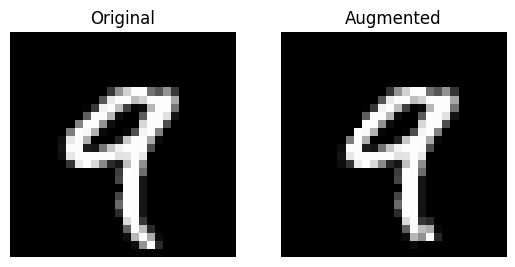

In [686]:
index = 4
norm_image = get_image(norm_dataset, index)
aug_image = get_image(aug_dataset, index)

side_by_side_plot(norm_image, aug_image, "Original", "Augmented")

### __Model Evaluation and Selection__

#### __Training and Evaluation Methods__

In [598]:
def evaluate(model, loader):
    model.eval()

    #Counters
    correct = 0
    total = 0

    #empty tensor of datatype long
    all_predicted = torch.tensor([], dtype=torch.long).to(device)


    '''with - gradient descent will be tracked outside of with block. Not tracking ->
    doesn't store unnecessary numbers (eg. intermediate activations) for calculating gradient; 
    Saves memory and its faster'''
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device) 

            outputs = model(images) #self.forward(images), uses __call__
            '''Return two tensors in tuple for max values (brightest neurons) and their indices per training 
            example in mini batch. Convention to store unimportant stuff in _. 1 as parameter input means 
            find max along dimension 1. Outputs = (batch_size, num_classes). Max outputs the max output neuron
            and index (number) per batch.
            '''
            _, predicted = torch.max(outputs, 1) #tensor

            #add this tensor for predicted numbers to the list; cat concatenates two tensors
            all_predicted = torch.cat((all_predicted, predicted), dim = 0) 

            #Update Counters
            total += labels.size(0) #size of first dimension (each minibatch)

            #Compare each tensor, which returns new tensor with each component being True or False
            #Sum counts the amount of True in the tensor
            correct += (predicted == labels).sum().item()
            accuracy = (correct/total) * 100
        return accuracy, all_predicted

In [599]:
def train_model(model, train_loader, optimizer, loss_f, num_epochs, val_loader = None):
    model.train() #prevents weird stuff (e.g. optimizer being weird)
    
    for epoch in range(num_epochs):

        #each iteration is one minibatch of images/labels
        for images, labels in train_loader: 
            images, labels = images.to(device), labels.to(device) #moves the tensor from virtual machine memory (mapped to RAM of server) to TPU memory

            '''Each parameter has its own special tensor (created per layer) 
            with a number for its partial derivative in .grad attribute of tensor; step() accesses these. Zeroing
            out graident ignores .grad and recalculates partials in backprop.'''
            optimizer.zero_grad()

            outputs = model(images) #passes this to forward

            target = F.one_hot(labels, num_classes=10).float() #numclasses is numcomponents; ex. 4 = [0,0,0,1,0,0,...]

            loss = loss_f(outputs, target) #tensor with scalar and computation graph
            loss.backward() #backward propogation to compute gradient

            optimizer.step() #updates model parameters (takes "step")

            #Colab
            #xm.optimizer_step(optimizer) #ensures gradient calculated first
            #xm.mark_step()


        #Print out stats for first and last epoch for k-folds cross validation
        if val_loader and (epoch == 0 or epoch == num_epochs - 1):
            train_accuracy, __ = evaluate(model, train_loader)
            val_accuracy, __ = evaluate(model, val_loader)

            print(f'Epoch {epoch + 1} -- Loss:{loss.item(): .4f}, Training Accuracy:{train_accuracy : .2f}%, Validation Accuracy:{val_accuracy : .2f}%')
        
            #return final validation accuracy to be averaged in k-folds
            if (epoch == num_epochs - 1):
                return val_accuracy
        elif not val_loader and (epoch == 0):
            print(f'Epoch {epoch + 1} -- Loss:{loss.item(): .4f}')
        elif not val_loader and (epoch == num_epochs - 1):
            print(f'Epoch {epoch + 1} -- Loss:{loss.item(): .4f}\n')

#### __Alter Hyper for Grid Search__

In [600]:
def alter_hyper(hypers, hypercombo):
    hypers.l_rate = hypercombo['l_rate']
    hypers.b_size = hypercombo['b_size']
    hypers.epochs = hypercombo['epochs']
    hypers.drop_rate = hypercombo['drop_rate']
    hypers.hidden_one = hypercombo['hidden_one']
    hypers.hidden_two = hypercombo['hidden_two']
    hypers.n_slope = hypercombo['n_slope']
    hypers.augment = hypercombo['augment']
    hypers.prob_augment = hypercombo['prob_augment']
    hypers.beta_one = hypercombo['beta_one']
    hypers.beta_two = hypercombo['beta_two']

#### __K-folds Cross Validation - Approach 1 (Splitting Training)__

In [273]:
#already ensure validation only used once per sample
def k_folds(folds, train_dataset, hypers, hypercombo = None, grid_search = False):

    kf = KFold(n_splits = folds, shuffle = True, random_state = 20)
    validation_accuracies = []

    if grid_search:
        alter_hyper(hypers, hypercombo)

    cross_entropy = nn.CrossEntropyLoss()

    for fold, (train_indices, val_indices) in enumerate(kf.split(train_dataset)):
        if (fold == 0):
            print(f'Fold {fold + 1}')
        else:
            print(f'\nFold {fold + 1}')

        #My actual validation
        val_transformed = create_dataset_t(train_dataset, val_indices, transform_norm)
        val_loader = DataLoader(val_transformed, batch_size = 512, shuffle=False)

        train_subset = Subset(train_dataset, train_indices)
        train_loader = norm_aug_loader_one(train_subset, hypers)
        
        model = NumberNN(hypers.hidden_one, hypers.hidden_two, hypers.drop_rate, hypers.n_slope).to(device) #ensures parameters reset and each fold is independent
        adam = optim.Adam(model.parameters(), lr= hypers.l_rate, betas=(0.9, 0.999), eps=1e-08) #forget info from EWMA

        last_epoch_val_accuracy = train_model(model, train_loader, optimizer = adam, loss_f = cross_entropy, 
                                              num_epochs = hypers.epochs, val_loader = val_loader)

        validation_accuracies.append(last_epoch_val_accuracy)

    mean_val_accuracy = np.mean(validation_accuracies)
    #Use average validation accuracy across all folds to evaluate model
    return mean_val_accuracy


In [ ]:
mean_val_accuracy = k_folds(10, train_dataset, hypers)
print(f'\n\033[1mMean Validation Accuracy Across All Folds: {mean_val_accuracy:.2f}%\033[0m\n')

#### __K-Folds Cross Validation - Approach 2 (Mapping Indices)__

In [601]:
full_train_dataset = ConcatDataset([norm_dataset, aug_dataset])

In [602]:
FOLDS = 10

def calc_alt_indices(norm_dataset, norm_train_indices, hypers, k_folds):
    '''This numberr maximizes amount of data for 70 30 prop; total_dataset_length*prob_normal.7 = len_normal; solve for total example length
    . This allows for 60_000 (70%) has normal transformation. Without +1 would be 59999'''
    total_training_examples = int((len(norm_dataset)/ (1-hypers.prob_augment)) + 1)

    #if k_folds take less data to maintain 70 30 prop
    len_val = len(norm_dataset)/FOLDS if k_folds else 0 #amount in validation set with k folds
    training_num = (len(norm_dataset) - len_val) if k_folds else total_training_examples

    num_norm_train_indices = int(training_num * (1-hypers.prob_augment))
    num_aug_train_indices = int(training_num * hypers.prob_augment)

    mapped_indices = norm_train_indices + len(norm_dataset) #maps indices to aug
    
    norm_train_indices = np.random.choice(norm_train_indices, num_norm_train_indices, replace = False) 
    norm_train_indices = norm_train_indices.reshape(-1) #should be 1D already
    aug_train_indices = np.random.choice(mapped_indices, num_aug_train_indices, replace = False)  

    
    return np.concatenate([norm_train_indices, aug_train_indices])

def norm_aug_loader_two(full_train_dataset, norm_dataset, norm_train_indices, hypers, k_folds = False):
    full_train_indices = calc_alt_indices(norm_dataset, norm_train_indices, hypers, k_folds)
    train_subset = Subset(full_train_dataset, full_train_indices)

    #Shuffles batch order + samples within batches per epoch
    return DataLoader(train_subset, batch_size = hypers.b_size, shuffle=True)
    

In [603]:
#random_state like seed; generates train/validation indices per fold
def k_folds_two(full_train_dataset, norm_dataset, hypers, hypercombo = None, grid_search = False):
    
    kf = KFold(n_splits = FOLDS, shuffle=True, random_state=20)
    validation_accuracies = []

    if grid_search:
        alter_hyper(hypers, hypercombo)
    
    '''by default split only works with indices arrays unless it can use length attribute of dataset, which Pytorch provides.
    This works too: norm_dataset.__len__(), dunder methods simplify syntax'''
    all_norm_indices = np.arange(len(norm_dataset))

    cross_entropy = nn.CrossEntropyLoss()

    for fold, (norm_train_indices, val_indices) in enumerate(kf.split(all_norm_indices)):
        if (fold == 0):
            print(f'Fold {fold + 1}')
        else:
            print(f'\nFold {fold + 1}')

        #Since we put in norm don't need to transform validation
        val_subset = Subset(norm_dataset, val_indices)
        val_loader = DataLoader(val_subset, batch_size=512, shuffle=False)

        train_loader = norm_aug_loader_two(full_train_dataset, norm_dataset, norm_train_indices, hypers, k_folds = True)
        
        model = NumberNN(hypers.hidden_one, hypers.hidden_two, hypers.drop_rate, hypers.n_slope).to(device) #ensures parameters reset and each fold is independent
        adam = optim.Adam(model.parameters(), lr = hypers.l_rate, betas=(hypers.beta_one, hypers.beta_two), eps=1e-08) #forget info from EWMA

        last_epoch_val_accuracy = train_model(model, train_loader, optimizer = adam, loss_f = cross_entropy, num_epochs = hypers.epochs, val_loader = val_loader)
        validation_accuracies.append(last_epoch_val_accuracy)

    mean_val_accuracy = np.mean(validation_accuracies)
    #Use average validation accuracy across all folds to evaluate model

    return mean_val_accuracy


In [539]:
#this works better
mean_val_accuracy = k_folds_two(full_train_dataset, norm_dataset, hypers)
print(f'\n\033[1mMean Validation Accuracy Across All Folds: {mean_val_accuracy:.2f}%\033[0m\n')
#.3 prob degrees = 15, translate = (0.03, 0.02), scale = (0.9, 1.03), shear = (-10, 10)) brightness=.22, contrast=0.25): 98.14% mean val
#98.30 with rearranging aug class distribution

Fold 1
Epoch 1 -- Loss: 0.4110, Training Accuracy: 90.00%, Validation Accuracy: 92.08%
Epoch 20 -- Loss: 0.0118, Training Accuracy: 98.95%, Validation Accuracy: 98.30%

Fold 2
Epoch 1 -- Loss: 0.4296, Training Accuracy: 88.26%, Validation Accuracy: 90.60%
Epoch 20 -- Loss: 0.0146, Training Accuracy: 99.01%, Validation Accuracy: 98.15%

Fold 3
Epoch 1 -- Loss: 0.3482, Training Accuracy: 88.91%, Validation Accuracy: 90.35%
Epoch 20 -- Loss: 0.0356, Training Accuracy: 99.09%, Validation Accuracy: 98.43%

Fold 4
Epoch 1 -- Loss: 0.3249, Training Accuracy: 90.08%, Validation Accuracy: 92.15%
Epoch 20 -- Loss: 0.0539, Training Accuracy: 98.65%, Validation Accuracy: 98.00%

Fold 5
Epoch 1 -- Loss: 0.2743, Training Accuracy: 89.42%, Validation Accuracy: 91.37%
Epoch 20 -- Loss: 0.0423, Training Accuracy: 99.07%, Validation Accuracy: 98.55%

Fold 6
Epoch 1 -- Loss: 0.3182, Training Accuracy: 90.21%, Validation Accuracy: 92.23%
Epoch 20 -- Loss: 0.0207, Training Accuracy: 98.93%, Validation Accu

#### __Hyperparameter Tuning with Gridsearch__

In [604]:
#All other hyperparameters previously tested
#Dictionary for gridsearch
hyperdict = {
    'l_rate': [hypers.l_rate],
    'b_size': [hypers.b_size],
    'epochs': [hypers.epochs],
    'drop_rate': [hypers.drop_rate],
    'hidden_one': [hypers.hidden_one],
    'hidden_two': [hypers.hidden_two],
    'n_slope': [hypers.n_slope],
    'augment': [hypers.augment],
    'prob_augment': [hypers.prob_augment],
    'beta_one': [0.85, 0.95, hypers.beta_one],
    'beta_two': [0.95, hypers.beta_two]
}

for dict in ParameterGrid(hyperdict):
    print(dict)

{'augment': True, 'b_size': 512, 'beta_one': 0.85, 'beta_two': 0.95, 'drop_rate': 0, 'epochs': 20, 'hidden_one': 1024, 'hidden_two': 128, 'l_rate': 0.001, 'n_slope': 0.01, 'prob_augment': 0.3}
{'augment': True, 'b_size': 512, 'beta_one': 0.85, 'beta_two': 0.999, 'drop_rate': 0, 'epochs': 20, 'hidden_one': 1024, 'hidden_two': 128, 'l_rate': 0.001, 'n_slope': 0.01, 'prob_augment': 0.3}
{'augment': True, 'b_size': 512, 'beta_one': 0.95, 'beta_two': 0.95, 'drop_rate': 0, 'epochs': 20, 'hidden_one': 1024, 'hidden_two': 128, 'l_rate': 0.001, 'n_slope': 0.01, 'prob_augment': 0.3}
{'augment': True, 'b_size': 512, 'beta_one': 0.95, 'beta_two': 0.999, 'drop_rate': 0, 'epochs': 20, 'hidden_one': 1024, 'hidden_two': 128, 'l_rate': 0.001, 'n_slope': 0.01, 'prob_augment': 0.3}
{'augment': True, 'b_size': 512, 'beta_one': 0.9, 'beta_two': 0.95, 'drop_rate': 0, 'epochs': 20, 'hidden_one': 1024, 'hidden_two': 128, 'l_rate': 0.001, 'n_slope': 0.01, 'prob_augment': 0.3}
{'augment': True, 'b_size': 512, '

In [605]:
def GridSearch(full_train_dataset, norm_dataset, hypers, hyperdict):
    best_hypers = None
    best_mean_val_accuracy = 0
    orig_hypers = hypers

    #iterable - generates on the fly to save memory; generates all possible dictionary combos
    for hypercombo in ParameterGrid(hyperdict): 
        #sometimes you save model also
        hypers = orig_hypers #reset hypers
        print(hypercombo)

        mean_val_accuracy = k_folds_two(full_train_dataset, norm_dataset, hypers, hypercombo, grid_search=True)
        print(f'\n\033[1mMean Validation Accuracy Across All Folds: {mean_val_accuracy:.2f}%\033[0m\n')
        
        if (mean_val_accuracy > best_mean_val_accuracy):
            best_mean_val_accuracy = mean_val_accuracy
            best_hypers = hypercombo
    
    hypers = orig_hypers
    return best_hypers, best_mean_val_accuracy

In [ ]:
#Always tune; batch size and learning rate relationship not always linear
best_hypers, best_mean_val_accuracy = GridSearch(full_train_dataset, norm_dataset, hypers, hyperdict)
print(f'\n\033[1mBest Hyperparameters: {best_hypers}\nBest Mean Validation Accuracy:{best_mean_val_accuracy: .2f}%\033[0m')

# Best Hyperparameters: {'l_rate': 0.001}, Mean Validation Accuracy: 97.59% - no augmentation
#Same hypers with augmentation - Mean Val: 98%

### __Training the Model__ 

#### __Creating the Normal/Augmented Training Dataset__

In [297]:
#Approach 1
norm_aug_loader = norm_aug_loader_one(train_dataset, hypers)

In [687]:
#Approach 2
norm_train_indices = np.arange(len(norm_dataset))
norm_aug_loader = norm_aug_loader_two(full_train_dataset, norm_dataset, norm_train_indices, hypers)

#### __Finding the Best Model Given the Hypers__

In [688]:
def train_keep_best_model(hypers, train_loader, test_loader, num_trials):
    best_model = None
    best_accuracy = 0
    cross_entropy = nn.CrossEntropyLoss()

    for i in range(0, num_trials):
        model = NumberNN(hypers.hidden_one, hypers.hidden_two, hypers.drop_rate, hypers.n_slope).to(device)
        adam = optim.Adam(model.parameters(), hypers.l_rate, betas=(hypers.beta_one, hypers.beta_two), eps=1e-08) 

        train_model(model = model, train_loader = train_loader, optimizer = adam, loss_f = cross_entropy, num_epochs = hypers.epochs)
        accuracy, __ = evaluate(model, test_loader)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
        
    return best_model, best_accuracy

In [690]:
model, test_accuracy = train_keep_best_model(hypers, norm_aug_loader, test_loader, 20)
print(f'\n{test_accuracy}')

Epoch 1 -- Loss: 0.2893
Epoch 20 -- Loss: 0.0956

Epoch 1 -- Loss: 0.3114
Epoch 20 -- Loss: 0.0215

Epoch 1 -- Loss: 0.2856
Epoch 20 -- Loss: 0.0270

Epoch 1 -- Loss: 0.2166
Epoch 20 -- Loss: 0.0522

Epoch 1 -- Loss: 0.2456
Epoch 20 -- Loss: 0.0265

Epoch 1 -- Loss: 0.2595
Epoch 20 -- Loss: 0.0310

Epoch 1 -- Loss: 0.1659
Epoch 20 -- Loss: 0.0410

Epoch 1 -- Loss: 0.1980
Epoch 20 -- Loss: 0.0652

Epoch 1 -- Loss: 0.2124
Epoch 20 -- Loss: 0.0422

Epoch 1 -- Loss: 0.4010
Epoch 20 -- Loss: 0.0054

Epoch 1 -- Loss: 0.2308
Epoch 20 -- Loss: 0.0323

Epoch 1 -- Loss: 0.2088
Epoch 20 -- Loss: 0.0280

Epoch 1 -- Loss: 0.2491
Epoch 20 -- Loss: 0.0084

Epoch 1 -- Loss: 0.2196
Epoch 20 -- Loss: 0.0285

Epoch 1 -- Loss: 0.2281
Epoch 20 -- Loss: 0.0362

Epoch 1 -- Loss: 0.2751
Epoch 20 -- Loss: 0.0386

Epoch 1 -- Loss: 0.2467
Epoch 20 -- Loss: 0.0294

Epoch 1 -- Loss: 0.3318
Epoch 20 -- Loss: 0.0131

Epoch 1 -- Loss: 0.2655
Epoch 20 -- Loss: 0.0275

Epoch 1 -- Loss: 0.3325
Epoch 20 -- Loss: 0.0376



### __Saving the Model__

In [691]:
#most data - approach 1 for splitting aug/normal; least is approach 2 because its among 60000
model_name = f'mlp-h1{hypers.hidden_one}-{hypers.prob_augment}aug2-altdistrib-{test_accuracy}.pth'
print(model_name)

mlp-h11024-0.3aug2-altdistrib-98.76.pth


#### __Local__

In [692]:
torch.save(model.state_dict(), f'../models/{model_name}')

#### __Colab__

In [ ]:
#files.download(f'{model_name}.pth')

model_downloads_path = os.path.join(os.path.expanduser("~"), "Downloads", f'{model_name}.pth')

model_destination_path = f'~/Documents/deep-learning-mnist/models/{model_name}.pth'

shutil.move(model_downloads_path, model_destination_path)

### __Loading the Saved Model__

In [613]:
def load_model(path_to_dict, hypers):
    # Instantiate the model
    model = NumberNN(hypers.hidden_one, hypers.hidden_two, hypers.drop_rate, hypers.n_slope).to(device)
    #Update model's parameters to what it was after training
    #model.load_state_dict(torch.load(f'../models/{trained_model}.pth'))
    model.load_state_dict(torch.load(path_to_dict, map_location = device))
    
    '''Sometimes in training some neurons turned off (called dropout) to prevent overfitting, but when testing you want all neurons in model to be used, 
    so eval fixes this as well as other settings for testing so model acts "normally"'''
    model.eval()

    return model

In [615]:
model = load_model('../models/mlp-h11024-0.3aug2-altdistrib-98.76.pth', hypers)

### __Evalulating/Testing the Model__

#### __Testing Accuracy for all Testing Data__

In [694]:
train_accuracy, __ = evaluate(model, loader = norm_aug_loader)
print(f'Train Accuracy:{train_accuracy : .2f}%')

test_accuracy, predicted = evaluate(model, loader = test_loader)
print(f'Test Accuracy:{test_accuracy : .2f}%')

Train Accuracy: 99.19%
Test Accuracy: 98.76%


#### __Recall Per Digit__

In [695]:
recalls = {}

for i in range(0,10):
    one_digit_indices = digit_indices(dataset = test_dataset, digit = i)
    one_digit_test_set = Subset(test_dataset, one_digit_indices)
    one_digit_loader = DataLoader(one_digit_test_set, batch_size = 512, shuffle = False)

    recall, __ = evaluate(model, loader = one_digit_loader)
    recalls[i] = recall

sorted_recalls = sorted(recalls.items(), key = itemgetter(1), reverse = True)

for digit, recall in sorted_recalls:
    print(f'Recall for {digit}:{recall: .2f}%')

Recall for 0: 99.59%
Recall for 1: 99.12%
Recall for 4: 99.08%
Recall for 2: 98.93%
Recall for 9: 98.81%
Recall for 5: 98.77%
Recall for 3: 98.61%
Recall for 8: 98.56%
Recall for 6: 98.54%
Recall for 7: 97.57%


#### __Confusion Matrix and More Summary Statistics__

In [696]:
'''Can't append lists otherwise you get nested list structure. Can either append each element to the list in loop or use extend().
Numpy array eventually required for creating the confusion matrix. Python lists memory works like ArrayLists while numpy arrays work
like normal arrays. Homogenous, contiguous np array means easier to calculate memory address of element so CPU can access stuff much faster 
for numpy. Unlike numpy, Python doesn't store objects themselves in list (fast) but instead a pointer to support heterogenous list. 
np array must be on CPU.'''

labels = []
for image, label in test_dataset:
    labels.append(label)

np_labels = np.array(labels)
np_predicted = predicted.to("cpu").numpy() #np arrays 

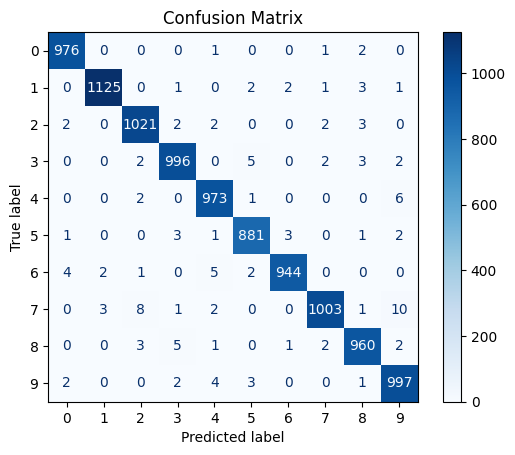

In [697]:
cm = confusion_matrix(np_labels, np_predicted)

#matplotlib object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in range(0,10)])

disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [698]:
'''Numbers often misclassified as 5 probably because there are less 5s in the dataset.'''
class_precisions = precision_score(np_labels, np_predicted, average='weighted')
class_recalls = recall_score(np_labels, np_predicted, average='weighted')
class_f1_scores = f1_score(np_labels, np_predicted, average='weighted')

report = classification_report(np_labels, np_predicted)

print(report)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.98      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.98      0.98      1028
           8       0.99      0.99      0.99       974
           9       0.98      0.99      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



### __Inputting a New Image__

#### __Pixelation__

In [699]:
def pixelate_image(image, pixelation_level):
    
    '''/ is floor division. Tuples have indices. Resize is changing # of pixels after knowing new 
    size of image, what makes it appear pixelated is then enlarging image so the few pixels are larger.
    Bilinear interpoloation is to get value of each pixel, look at weighted (based on distance) average of 
    4 nearest pixels of where it would go to determine new value. Then split those big pixels up again 
    so the size is same as original but looks more pixelated.'''

    #open and greyscale image (compress to 1 channel)

    new_size = (image.size[0] // pixelation_level, image.size[1] // pixelation_level)
    pixelated = image.resize(new_size,resample=Image.BILINEAR)

    pixelated = pixelated.resize((28, 28))
    
    return pixelated

#Preprocess using functions of the Image class
def preprocess_image(image, pixelation_level):
    image = pixelate_image(image, pixelation_level)
    image = transform_norm(image)  #images -> pixel values-> normalize
    image = image.unsqueeze(0)  #Add singleton dimension (batch_size) to image; not used, but specific shape necessary for model
    return image

def preprocess_no_pixelation(image):
    image = image.resize((28, 28))
    image = transform_norm(image) 
    image = image.unsqueeze(0)
    return image

In [700]:
orig = Image.open('../data/test-images/9-1.png').convert('L')

#pixelation slightly worse outcome
pixelation_level = 1 #1 has effect of no pixelation
pixelated_image = pixelate_image(orig, pixelation_level)

image_transformed = preprocess_image(orig, pixelation_level).to(device)
#image_transformed = preprocess_no_pixelation(orig).to(device)
with torch.no_grad():
    outputs = model(image_transformed)
    _, predicted = torch.max(outputs, dim = 1)

    #softmax takes care of negative outputs
    probabilities = F.softmax(outputs, dim = 1) #probabilities[i] that contains softmax for outputs of i+1 image 

#[(number, probability tensor)...]; enumerate packs into tuple with counter
prob_tuples = list(enumerate(probabilities[0])) 

#to sort by max, extract probability with itemgetter
prob_tuples.sort(key = itemgetter(1), reverse = True)

for number, probability in prob_tuples:
    print(f'Probability of {number}:{probability.item() * 100: .3f}%')

print(f'\nPredicted Number: {predicted.item()}')

Probability of 9: 98.448%
Probability of 8: 1.227%
Probability of 2: 0.276%
Probability of 7: 0.032%
Probability of 1: 0.008%
Probability of 3: 0.007%
Probability of 4: 0.002%
Probability of 0: 0.000%
Probability of 5: 0.000%
Probability of 6: 0.000%

Predicted Number: 9


#### __Visualizing the Pixelated Image__

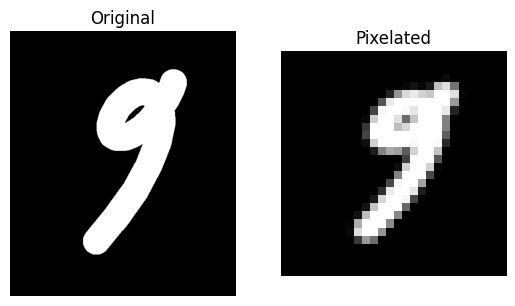

In [701]:
side_by_side_plot(orig, pixelated_image, "Original", "Pixelated")